RNNの最も基本的な活用例としては機械翻訳があります。これは時系列を入力し、時系列を出力するSequence to Sequenceの手法によって行えます。  

## 【問題1】機械翻訳の実行とコードリーディング  
Keras公式のサンプルコードで、短い英語からフランス語への変換が行えるのでこれを動かしてください。  

[keras/lstm_seq2seq.py at master · keras-team/keras](https://github.com/keras-team/keras/blob/master/examples/lstm_seq2seq.py)

その上でこのサンプルコードの各部分がどういった役割かを読み取り、まとめてください。以下のようにどこからどこの行が何をしているかを記述してください。  

（例）  

51から55行目 : ライブラリのimport  
57から62行目 : ハイパーパラメータの設定

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/DIC/sprint25/')

In [6]:
'''
#Sequence to sequence example in Keras (character-level).
This script demonstrates how to implement a basic character-level
sequence-to-sequence model. We apply it to translating
short English sentences into short French sentences,
character-by-character. Note that it is fairly unusual to
do character-level machine translation, as word-level
models are more common in this domain.
**Summary of the algorithm**
- We start with input sequences from a domain (e.g. English sentences)
    and corresponding target sequences from another domain
    (e.g. French sentences).
- An encoder LSTM turns input sequences to 2 state vectors
    (we keep the last LSTM state and discard the outputs).
- A decoder LSTM is trained to turn the target sequences into
    the same sequence but offset by one timestep in the future,
    a training process called "teacher forcing" in this context.
    It uses as initial state the state vectors from the encoder.
    Effectively, the decoder learns to generate `targets[t+1...]`
    given `targets[...t]`, conditioned on the input sequence.
- In inference mode, when we want to decode unknown input sequences, we:
    - Encode the input sequence into state vectors
    - Start with a target sequence of size 1
        (just the start-of-sequence character)
    - Feed the state vectors and 1-char target sequence
        to the decoder to produce predictions for the next character
    - Sample the next character using these predictions
        (we simply use argmax).
    - Append the sampled character to the target sequence
    - Repeat until we generate the end-of-sequence character or we
        hit the character limit.
**Data download**
[English to French sentence pairs.
](http://www.manythings.org/anki/fra-eng.zip)
[Lots of neat sentence pairs datasets.
](http://www.manythings.org/anki/)
**References**
- [Sequence to Sequence Learning with Neural Networks
   ](https://arxiv.org/abs/1409.3215)
- [Learning Phrase Representations using
    RNN Encoder-Decoder for Statistical Machine Translation
    ](https://arxiv.org/abs/1406.1078)
'''
from __future__ import print_function

from keras.models import Model
from keras.layers import Input, LSTM, Dense
import numpy as np
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(patience=0, verbose=1)

batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.
#文章数の上限を１００００にする
# Path to the data txt file on disk.
data_path = 'fra-eng/fra.txt'
#翻訳したい言語の対応表が載っている。
# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
    #開いたファイルを改行ごとに分解し全て読み込む
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text = line.split('\t')
    #タブで区切ってある翻訳したい単語と翻訳後の単語を変数に代入している
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    #インプットしたい単語を単語集にまとめる
    target_texts.append(target_text)
    #翻訳後に正解として出したい単語を単語集にまとめる
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
            #インプットしたい文字を文字集にまとめる
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)
            #翻訳後に正解として出したい文字を文字集にまとめる

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
#単語とidをタプルで辞書にセットしている
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])
#単語とidをタプルで辞書にセットしている
encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.

# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
#https://github.com/keras-team/keras/issues/2054
#上記サイトにコメントがあるように頭にNoneを引数に持つと可変長になる
encoder = LSTM(latent_dim, return_state=True)
#LSTMクラスのオブジェクトを作っている。return_state=Trueで最後の状態を戻り値として返す。
#LSTMの最後の状態を他のLSTMの初期状態として用いるときなどに利用する

encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
#Modelはインプととアウトプットの形式を指定できる。
# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          callbacks=[early_stopping],
          validation_split=0.2)
# Save model
model.save('s2s.h5')
#作ったモデルをs2s.h5の名前で保存
# Next: inference mode (sampling).
# Here's the drill:
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states

# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)
#LSTMからモデルを生成
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    #モデルから翻訳した文章を生成する
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence


for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

Number of samples: 10000
Number of unique input tokens: 70
Number of unique output tokens: 93
Max sequence length for inputs: 16
Max sequence length for outputs: 59
Train on 8000 samples, validate on 2000 samples
Epoch 1/100
8000/8000 [==============================] - 14s 2ms/step - loss: 0.9177 - val_loss: 0.9408
Epoch 2/100
8000/8000 [==============================] - 13s 2ms/step - loss: 0.7253 - val_loss: 0.7565
Epoch 3/100
8000/8000 [==============================] - 12s 2ms/step - loss: 0.6164 - val_loss: 0.6870
Epoch 4/100
8000/8000 [==============================] - 12s 2ms/step - loss: 0.5604 - val_loss: 0.6259
Epoch 5/100
8000/8000 [==============================] - 12s 2ms/step - loss: 0.5202 - val_loss: 0.5896
Epoch 6/100
8000/8000 [==============================] - 12s 2ms/step - loss: 0.4888 - val_loss: 0.5572
Epoch 7/100
8000/8000 [==============================] - 12s 2ms/step - loss: 0.4632 - val_loss: 0.5351
Epoch 8/100
8000/8000 [==============================] - 12

/usr/local/lib/python3.6/dist-packages/keras/engine/network.py:877: UserWarning: Layer lstm_6 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_5/while/Exit_2:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'lstm_5/while/Exit_3:0' shape=(?, 256) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


-
Input sentence: Go.
Decoded sentence: Allez !

-
Input sentence: Hi.
Decoded sentence: Arrête de troid.

-
Input sentence: Run!
Decoded sentence: Attendez !

-
Input sentence: Run!
Decoded sentence: Attendez !

-
Input sentence: Who?
Decoded sentence: Qui est chant ?

-
Input sentence: Wow!
Decoded sentence: Laissez-toi !

-
Input sentence: Fire!
Decoded sentence: Attendez !

-
Input sentence: Help!
Decoded sentence: Continuez à rouler !

-
Input sentence: Jump.
Decoded sentence: Venez chez moi.

-
Input sentence: Stop!
Decoded sentence: Arrête de te vris !

-
Input sentence: Stop!
Decoded sentence: Arrête de te vris !

-
Input sentence: Stop!
Decoded sentence: Arrête de te vris !

-
Input sentence: Wait!
Decoded sentence: Attendez une bonche !

-
Input sentence: Wait!
Decoded sentence: Attendez une bonche !

-
Input sentence: Go on.
Decoded sentence: Allez !

-
Input sentence: Go on.
Decoded sentence: Allez !

-
Input sentence: Go on.
Decoded sentence: Allez !

-
Input sentence: Hel

他の活用例としてイメージキャプショニングがあります。画像に対する説明の文章を推定するタスクです。これは画像を入力し、時系列を出力するImage to Sequenceの手法によって行えます。  

[pytorch-tutorial/tutorials/03-advanced/image_captioning at master · yunjey/pytorch-tutorial](https://github.com/yunjey/pytorch-tutorial/tree/master/tutorials/03-advanced/image_captioning)

イメージキャプショニングは学習に多くの時間がかかるため、ここでは学習済みの重みが公開されている実装を動かすことにします。Kerasには平易に扱える実装が公開されていないため、今回はPyTorchによる実装を扱います。  

【問題2】イメージキャプショニングの学習済みモデルの実行  
上記実装において5. Test the modelの項目を実行してください。また、自身で用意した画像に対しても文章を生成してください。これらに対してどういった文章が出力されたかを記録して提出してください。  

データセットからの学習は行わず、学習済みの重みをダウンロードして利用します。  

注意点として、デフォルトで設定されている重みのファイル名と、ダウンロードできる重みのファイル名は異なっています。ここは書き換える必要があります。

In [1]:
%run sample.py --image='png/neko.jpeg'

<start> a cat laying on a bed next to a cat . <end>


<img src="./png/neko.jpeg">

<start> a hot dog with a hot dog on a bun . <end>


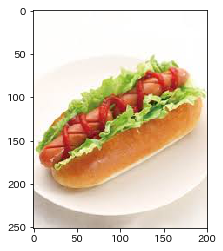

In [2]:
%run sample.py --image='png/hotdog.jpeg'

## 【問題3】Kerasで動かしたい場合はどうするかを調査
PyTorchによる実装を動かしましたが、何らかの理由からKerasで動かしたい状況が考えられます。どういった手順を踏むことになるか調査し、できるだけ詳しく説明してください。

特に今回はPyTorchのための学習済みの重みをKerasで使えるようにしたいので、その点については必ず触れてください。

### １．学習済みモデルをPyTorchからKerasに変換させる
- MMdnn(Microsoft Researchにより開発が進められているオープンソースの深層学習モデルの変換と可視化を行うツール)を利用して学習済みモデルの変換を行う。
  
以下のフレームワークでモデルの相互運用が可能。  
Caffe、Keras、Tensorflow、CNTK、MXNet、PyTorch、CoreML

- 参考サイト  
[深層学習モデルの相互変換ツールMMdnnを試す](https://qiita.com/koppe/items/7f85f5411539390c4499)

$ pip install mmdnn


### ２．コードの書き換え
- PyTorchにより実装されているモデル構築から推測までのコードをKerasを利用して書き換える。
- 注意事項

### Channel First
PyTorchではモデルの入力と出力がChannel Firstの形式になっている。  
Channel Firstとは画像の次元の並びが(C, H, W)のようにChannelの次元が最初になっていること。  
KerasではChannel Lastになっているため、(H, W, C)のようにChannelの次元が最後にくる。  
  
実際にモデルに入力するときは、バッチサイズも合わせた4次元で表現する必要があるため、  
PyTorch：(N, C, H, W)  
Keras：(N, H, W, C)  
となる。  

- 以下参考サイト  
[Kerasを勉強した後にPyTorchを勉強して躓いたこと](https://qiita.com/takurooo/items/e356dfdeec768d8f7146)